In [1]:

import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange


### **Importing Drive (Dataset-University)**

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
plt.figure(figsize=(20,10)) 


<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [4]:

class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()
  


In [5]:

def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M




In [6]:

def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def ImageBounds(img, H):

    h, w= img.shape[0], img.shape[1]
    p1 = np.dot(H, np.array([0, 0, 1]))
    p2 = np.dot(H, np.array([0, h - 1, 1]))
    p3 = np.dot(H, np.array([w - 1, 0, 1]))
    p4 = np.dot(H, np.array([w - 1, h - 1, 1]))
    x1 = p1[0] / p1[2]
    y1 = p1[1] / p1[2]
    x2 = p2[0] / p2[2]
    y2 = p2[1] / p2[2]
    x3 = p3[0] / p3[2]
    y3 = p3[1] / p3[2]
    x4 = p4[0] / p4[2]
    y4 = p4[1] / p4[2]
    minX = math.ceil(min(x1, x2, x3, x4))
    minY = math.ceil(min(y1, y2, y3, y4))
    maxX = math.ceil(max(x1, x2, x3, x4))
    maxY = math.ceil(max(y1, y2, y3, y4))

    return int(minX), int(minY), int(maxX), int(maxY)
  
  
def Populate_Images(img, accumulator, H, bw):
  


    h, w = img.shape[0], img.shape[1]
    minX, minY, maxX, maxY = ImageBounds(img, H)

    for i in range(minX, maxX + 1):
        for j in range(minY, maxY + 1):
            p = np.dot(np.linalg.inv(H), np.array([i, j, 1]))

            x = p[0]
            y = p[1]
            z = p[2]

            _x = int(x / z)
            _y = int(y / z)

            if _x < 0 or _x >= w - 1 or _y < 0 or _y >= h - 1:
                continue

            if img[_y, _x, 0] == 0 and img[_y, _x, 1] == 0 and img[_y, _x, 2] == 0:
                continue

            wt = 1.0

            if _x >= minX and _x < minX + bw:
                wt = float(_x - minX) /bw
            if _x <= maxX and _x > maxX -bw:
                wt = float(maxX - _x) /bw

            accumulator[j, i, 3] += wt

            for c in range(3):
                accumulator[j, i, c] += img[_y, _x, c] *wt


  

In [7]:

def Image_Stitch(Imagesall, blendWidth, accWidth, accHeight, translation):
    channels=3
    #width=720

    acc = np.zeros((accHeight, accWidth, channels + 1))
    M = np.identity(3)
    for count, i in enumerate(Imagesall):
        M = i.position
        img = i.img
        M_trans = translation.dot(M)
        Populate_Images(img, acc, M_trans, blendWidth)
    
    height, width = acc.shape[0], acc.shape[1]

    img = np.zeros((height, width, 3))
    for i in range(height):
        for j in range(width):
            weights = acc[i, j, 3]
            if weights > 0:
                for c in range(3):
                    img[i, j, c] = int(acc[i, j, c] / weights)
                    

    Imagefull = np.uint8(img)
    M = np.identity(3)
    for count, i in enumerate(Imagesall):
        if count != 0 and count != (len(Imagesall) - 1):
            continue

        M = i.position

        M_trans = translation.dot(M)

        p = np.array([0.5 * width, 0, 1])
        p = M_trans.dot(p)

        
        if count == 0:
            x_init, y_init = p[:2] / p[2]
        
        if count == (len(Imagesall) - 1):
            x_final, y_final = p[:2] / p[2]
    
    
    A = np.identity(3)
    croppedImage = cv2.warpPerspective(
        Imagefull, A, (accWidth, accHeight), flags=cv2.INTER_LINEAR
    )
    displayplot(croppedImage, 'Final Stitched Image')



In [8]:
#!pip uninstall opencv-python
#!pip install opencv-contrib-python===4.4.0.44
#!pip install opencv-python==4.4.0.44
#!pip install opencv-contrib-python==4.4.0.44

In [9]:
import cv2
print(cv2.__version__)

4.1.2


## **Reading GPS and Metdata information**
**Georeferencing through the data (Incomplete)**

In [152]:
from PIL import Image, ExifTags
img = Image.open(f"{left_files_path[0]}")
exif = { ExifTags.TAGS[k]: v for k, v in img._getexif().items() if k in ExifTags.TAGS }

In [153]:
from PIL.ExifTags import TAGS

def get_exif(filename):
    image = Image.open(filename)
    image.verify()
    return image._getexif()
    
def get_labeled_exif(exif):
    labeled = {}
    for (key, val) in exif.items():
        labeled[TAGS.get(key)] = val

    return labeled

exif = get_exif(f"{left_files_path[0]}")
labeled = get_labeled_exif(exif)
print(labeled)

{'ExifVersion': b'0230', 'ApertureValue': (497, 100), 'DateTimeOriginal': '2018:09:02 05:24:35', 'ExposureBiasValue': (0, 10), 'MaxApertureValue': (297, 100), 'SubjectDistance': (4294967295, 1000), 'MeteringMode': 1, 'LightSource': 9, 'Flash': 16, 'FocalLength': (185, 10), 'ExifImageWidth': 6000, 'ExifImageHeight': 4000, 'FlashEnergy': (0, 0), 'FocalPlaneXResolution': (2558, 1), 'FocalPlaneYResolution': (2558, 1), 'FocalPlaneResolutionUnit': 3, 'SubsecTimeOriginal': '00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', 'ProcessingSoftware': 'eMotion 3.7.0b2', 'Make': 'senseFly', 'Model': 'senseFly Aeria X', 'UniqueCameraModel': 'senseFly Aeria X', 'ExposureTime': (10, 20000), 'XResolution': (72, 1), 'YResolution': (72, 1), 'FNumber': (56, 10), 'ExposureProgram': 4, 'GPSInfo': {0: b'\x02\x03\x00\x00', 1: 'N', 2: ((14, 1), (4, 1), (8400922, 1000000)), 3: 'E', 4: ((100, 1), (37, 1), (5044852, 1000000)), 5: b'\x00', 6: (2534731, 10000), 7: ((5, 1), (24, 1), (35433, 1000

In [154]:
print(TAGS)

{11: 'ProcessingSoftware', 254: 'NewSubfileType', 255: 'SubfileType', 256: 'ImageWidth', 257: 'ImageLength', 258: 'BitsPerSample', 259: 'Compression', 262: 'PhotometricInterpretation', 263: 'Thresholding', 264: 'CellWidth', 265: 'CellLength', 266: 'FillOrder', 269: 'DocumentName', 270: 'ImageDescription', 271: 'Make', 272: 'Model', 273: 'StripOffsets', 274: 'Orientation', 277: 'SamplesPerPixel', 278: 'RowsPerStrip', 279: 'StripByteCounts', 280: 'MinSampleValue', 281: 'MaxSampleValue', 282: 'XResolution', 283: 'YResolution', 284: 'PlanarConfiguration', 285: 'PageName', 288: 'FreeOffsets', 289: 'FreeByteCounts', 290: 'GrayResponseUnit', 291: 'GrayResponseCurve', 292: 'T4Options', 293: 'T6Options', 296: 'ResolutionUnit', 297: 'PageNumber', 301: 'TransferFunction', 305: 'Software', 306: 'DateTime', 315: 'Artist', 316: 'HostComputer', 317: 'Predictor', 318: 'WhitePoint', 319: 'PrimaryChromaticities', 320: 'ColorMap', 321: 'HalftoneHints', 322: 'TileWidth', 323: 'TileLength', 324: 'TileOffse

In [155]:
from PIL.ExifTags import GPSTAGS

def get_geotagging(exif):
    if not exif:
        raise ValueError("No EXIF metadata found")

    geotagging = {}
    for (idx, tag) in TAGS.items():
        if tag == 'GPSInfo':
            if idx not in exif:
                raise ValueError("No EXIF geotagging found")

            for (key, val) in GPSTAGS.items():
                if key in exif[idx]:
                    geotagging[val] = exif[idx][key]
    return geotagging

In [156]:
all_files_path = left_files_path[::-1] + right_files_path[1:]
for file1 in all_files_path:
  exif = get_exif(f"{file1}")
  geotags = get_geotagging(exif)
  print(geotags)

{'GPSVersionID': b'\x02\x03\x00\x00', 'GPSLatitudeRef': 'N', 'GPSLatitude': ((14, 1), (3, 1), (52645639, 1000000)), 'GPSLongitudeRef': 'E', 'GPSLongitude': ((100, 1), (37, 1), (5068784, 1000000)), 'GPSAltitudeRef': b'\x00', 'GPSAltitude': (2548340, 10000), 'GPSTimeStamp': ((5, 1), (23, 1), (43139, 1000)), 'GPSStatus': 'A', 'GPSMapDatum': 'WGS-84\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', 'GPSDateStamp': '2018:09:02'}
{'GPSVersionID': b'\x02\x03\x00\x00', 'GPSLatitudeRef': 'N', 'GPSLatitude': ((14, 1), (3, 1), (54228735, 1000000)), 'GPSLongitudeRef': 'E', 'GPSLongitude': ((100, 1), (37, 1), (5056880, 1000000)), 'GPSAltitudeRef': b'\x00', 'GPSAltitude': (2576516, 10000), 'GPSTimeStamp': ((5, 1), (23, 1), (47868, 1000)), 'GPSStatus': 'A', 'GPSMapDatum': 'WGS-84\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', 'GPSDateStamp': '2018:09:02'}
{'GPSVersionID': b'\x02\x03\x00\x00', 'GPSLatitudeRef': 'N', 'GPSLatitude': ((14, 1), (3, 1), (55798385, 1000000)), 'GPSLongitudeRef': '

In [157]:
def get_decimal_from_dms(dms, ref):

    degrees = dms[0][0] / dms[0][1]
    minutes = dms[1][0] / dms[1][1] / 60.0
    seconds = dms[2][0] / dms[2][1] / 3600.0

    if ref in ['S', 'W']:
        degrees = -degrees
        minutes = -minutes
        seconds = -seconds

    return round(degrees + minutes + seconds, 5)

def get_coordinates(geotags):
    lat = get_decimal_from_dms(geotags['GPSLatitude'], geotags['GPSLatitudeRef'])

    lon = get_decimal_from_dms(geotags['GPSLongitude'], geotags['GPSLongitudeRef'])

    return (lat,lon)


(14.06462, 100.61807)
(14.06506, 100.61807)
(14.0655, 100.61804)
(14.06594, 100.61805)
(14.06636, 100.61805)
(14.0668, 100.61805)
(14.06723, 100.61802)
(14.06768, 100.61804)
(14.06812, 100.61804)
(14.06857, 100.61807)
(14.069, 100.61807)
(14.06944, 100.61807)
(14.06988, 100.61804)
(14.07032, 100.61804)
(14.07076, 100.61804)
(14.0712, 100.61806)
(14.07163, 100.61806)
(14.07208, 100.61807)
(14.07251, 100.61806)
(14.07296, 100.61805)
(14.0734, 100.61807)


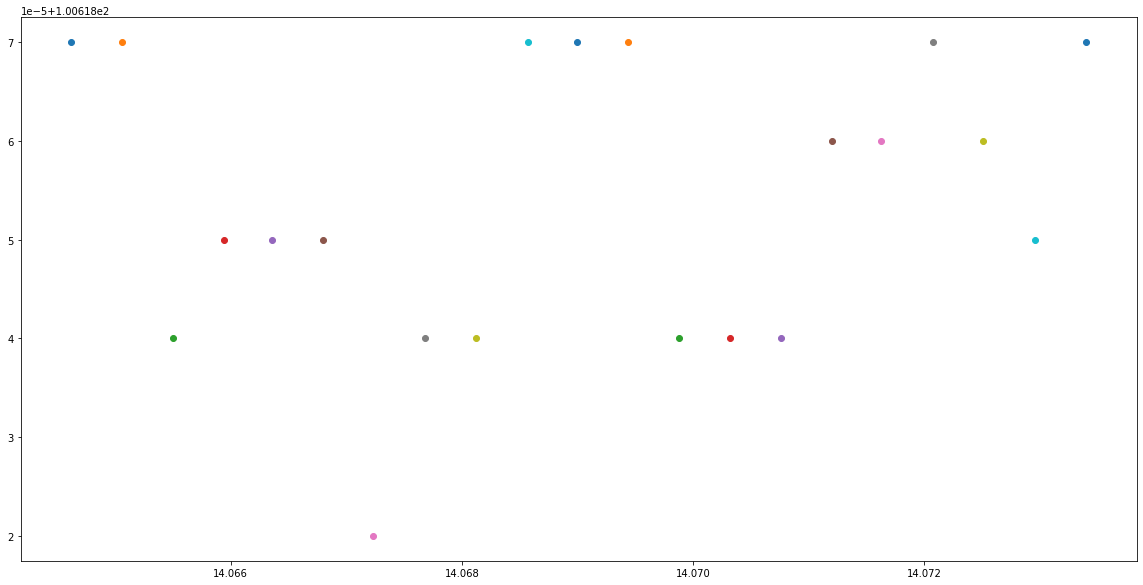

In [158]:
plt.figure(figsize = (20,10))
for file1 in all_files_path:
  exif = get_exif(f"{file1}")
  geotags = get_geotagging(exif)
  print(get_coordinates(geotags))
  geocoord = get_coordinates(geotags)
  plt.scatter(x=geocoord[0], y=geocoord[1])


In [165]:
!pip install pyproj

     |████████████████████████████████| 6.6MB 10.6MB/s 


In [166]:
import pyproj
from pyproj import Proj

In [37]:
!pip install GDAL

In [160]:
import gdal

In [161]:
# open the dataset and get the geo transform matrix
ds = gdal.Open((f"{all_files_path[0]}")) 
xoff, pix_width, rotatonal, yoff, px_height, rotation_second = ds.GetGeoTransform()

In [162]:
# Describe source image size
x_height = ds.RasterXSize
y_width = ds.RasterYSize

In [167]:
p = pyproj.Proj(proj='utm', zone=47, ellps='WGS84')

In [168]:
lat_file,long_file = get_coordinates(get_geotagging(get_exif(f"{all_files_path[0]}")))
UTM_east, UTM_north = p(long_file, lat_file)

In [169]:
upper_pix = x_height/2
left_pix = y_width/2

In [170]:
print(ds.GetMetadata_Dict())

{'EXIF_ApertureValue': '(4.97)', 'EXIF_DateTimeOriginal': '2018:09:02 05:23:42', 'EXIF_ExifVersion': '0230', 'EXIF_ExposureBiasValue': '(0)', 'EXIF_ExposureProgram': '4', 'EXIF_ExposureTime': '(0.0005)', 'EXIF_Flash': '16', 'EXIF_FlashEnergy': '(0)', 'EXIF_FNumber': '(5.6)', 'EXIF_FocalLength': '(18.5)', 'EXIF_FocalLengthIn35mmFilm': '28', 'EXIF_FocalPlaneResolutionUnit': '3', 'EXIF_FocalPlaneXResolution': '(2558)', 'EXIF_FocalPlaneYResolution': '(2558)', 'EXIF_GPSAltitude': '(254.834)', 'EXIF_GPSAltitudeRef': '00', 'EXIF_GPSDateStamp': '2018:09:02', 'EXIF_GPSLatitude': '(14) (3) (52.6456)', 'EXIF_GPSLatitudeRef': 'N', 'EXIF_GPSLongitude': '(100) (37) (5.06878)', 'EXIF_GPSLongitudeRef': 'E', 'EXIF_GPSMapDatum': 'WGS-84', 'EXIF_GPSStatus': 'A', 'EXIF_GPSTimeStamp': '(5) (23) (43.139)', 'EXIF_GPSVersionID': '0x2 0x3 00 00', 'EXIF_ISOSpeedRatings': '500', 'EXIF_LightSource': '9', 'EXIF_Make': 'senseFly', 'EXIF_MakerNote': '\x01', 'EXIF_MaxApertureValue': '(2.97)', 'EXIF_MeteringMode': '1'

In [ ]:
x_tf = UTM_east - 0.5*pix_area - (pix_area * upper_pix)
y_tf = UTM_north + 0.5*pix_area + (pix_area * left_pix)

## **Reading images and Extracting SuperPoint Keypoints and Descriptors from each image**

In [10]:
!pip install ipython-autotime

%load_ext autotime


time: 177 µs (started: 2021-06-05 12:20:27 +00:00)


In [ ]:
'''
files_all=[]
for file in os.listdir("/content/drive/My Drive/Small_Village"):
    if file.endswith(".JPG"):
      files_all.append(file)



#files_all = os.listdir('/content/drive/My Drive/tech_park/')
files_all.sort()
folder_path = '/content/drive/My Drive/Small_Village/'

centre_file = folder_path + files_all[7]
left_files_path_rev = []
right_files_path = []

for file in files_all[4:8]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[7:10]:
  right_files_path.append(folder_path + file)
'''

time: 10.1 ms (started: 2021-06-03 13:19:52 +00:00)


In [ ]:
'''
files_all=[]
for file in os.listdir("/content/drive/My Drive/tech_park"):
    if file.endswith(".JPG"):
      files_all.append(file)



#files_all = os.listdir('/content/drive/My Drive/tech_park/')
files_all.sort()
folder_path = '/content/drive/My Drive/tech_park/'

centre_file = folder_path + files_all[14]
left_files_path_rev = []
right_files_path = []

for file in files_all[:15]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[14:29]:
  right_files_path.append(folder_path + file)
'''

time: 11.9 ms (started: 2021-06-03 13:45:27 +00:00)


In [10]:

files_all=[]
for file in os.listdir("/content/drive/My Drive/Uni"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/My Drive/Uni/'

centre_file = folder_path + files_all[11]
left_files_path_rev = []
right_files_path = []

for file in files_all[:12]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[11:23]:
  right_files_path.append(folder_path + file)

In [11]:
print(left_files_path)

['/content/drive/My Drive/Uni/IX-11-01917_0004_0012.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0011.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0010.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0009.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0008.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0007.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0006.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0005.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0004.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0003.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0002.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0001.JPG']


In [12]:
print(right_files_path)

['/content/drive/My Drive/Uni/IX-11-01917_0004_0012.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0013.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0014.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0015.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0016.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0017.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0018.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0019.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0020.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0021.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0022.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0023.JPG']


### **Reading Images as BGR and Grayscale and Image Enhancement**

In [13]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.5,fy=0.5, interpolation = cv2.INTER_CUBIC)
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)



In [128]:
images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_img_sat= cv2.imread(file,0)
  #left_img = cv2.resize(left_img_sat,None,fx=0.75, fy=0.75, interpolation = cv2.INTER_CUBIC)
  #left_img_gray = cv2.cvtColor(left_img,cv2.COLOR_BGR2GRAY)
  interp = cv2.INTER_CUBIC
  grayim = left_img_sat
  grayim = clahe.apply(grayim)
  grayim = cv2.resize(left_img_sat,None,fx=0.5, fy=0.5, interpolation=interp)
  grayim = (grayim.astype('float32') / 255.)

  images_left.append(grayim)


for file in tqdm(right_files_path):
  right_img_sat= cv2.imread(file,0)
  #right_img = cv2.resize(right_img_sat,None,fx=0.75,fy=0.75, interpolation = cv2.INTER_CUBIC)
  #right_img_gray = cv2.cvtColor(right_img,cv2.COLOR_BGR2GRAY)
  interp = cv2.INTER_CUBIC
  grayim = right_img_sat
  grayim = clahe.apply(grayim)
  grayim = cv2.resize(right_img_sat,None,fx=0.5, fy=0.5, interpolation=interp)
  grayim = (grayim.astype('float32') / 255.)

  images_right.append(grayim)




time: 4.04 s (started: 2021-06-05 13:36:03 +00:00)


In [ ]:
'''
#brisk = cv2.KAZE_create()
Threshl=60;
Octaves=8; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

#brisk = cv2.ORB_create(5000)

#brisk = cv2.AKAZE_create()


keypoints_all_left = []
descriptors_all_left = []
points_all_left=[]

keypoints_all_right = []
descriptors_all_right = []
points_all_right=[]

for imgs in tqdm(images_left_bgr):
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left.append(kpt)
  descriptors_all_left.append(descrip)
  points_all_left.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right.append(kpt)
  descriptors_all_right.append(descrip)
  points_all_right.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))
  '''

### **Cloning SuperPoint Pretrained Network**

In [114]:
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

fatal: destination path 'SuperPointPretrainedNetwork' already exists and is not an empty directory.
time: 144 ms (started: 2021-06-05 13:32:08 +00:00)


In [14]:
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = 'True'

In [15]:
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()

class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
        self.cell = 8 # Size of each output cell. Keep this fixed.
        self.border_remove = 4 # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
          # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
          # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):

        grid = np.zeros((H, W)).astype(int) # Track NMS data.
        inds = np.zeros((H, W)).astype(int) # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int) # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i], rcorners[0,i]] = 1
            inds[rcorners[1,i], rcorners[0,i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
          # Account for top and left padding.
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 #Image must be grayscale.
        assert img.dtype == np.float32 #Image must be float32.
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        
        # --- Process points.
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = np.transpose(nodust, [1, 2, 0])
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell]) 
        prob_map = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap, coarse_desc


    def key_pt_sampling(self, img, heat_map, coarse_desc, sampled):
        
        H, W = img.shape[0], img.shape[1]

        xs, ys = np.where(heat_map >= self.conf_thresh) # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        print("number of pts selected :", len(xs))
        
        
        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heat_map[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]] # Sort by confidence.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        pts = pts[:,0:sampled] #we take 2000 keypoints with highest probability from heatmap for our benchmark
        
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
          # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()            
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

            
        return pts, desc

## **Loading and Initialing the SuperPoint Pretrained Network**

In [17]:
print('Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 3,conf_thresh = 0.01,nn_thresh=0.5)
print('Successfully loaded pre-trained network.')

Loading pre-trained network.
Successfully loaded pre-trained network.


## **Now Extracting Keypoints and Descriptors from all images and storing them**

In [18]:

keypoints_all_left = []
descriptors_all_left = []
points_all_left=[]

keypoints_all_right = []
descriptors_all_right = []
points_all_right=[]

for lfpth in tqdm(images_left):
  heatmap1, coarse_desc1 = fe.run(lfpth)
  pts_1, desc_1 = fe.key_pt_sampling(lfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_left.append(to_kpts(pts_1.T))
  descriptors_all_left.append(desc_1.T)
  points_all_left.append(pts_1.T)


for rfpth in tqdm(images_right):
  heatmap1, coarse_desc1 = fe.run(rfpth)
  pts_1, desc_1 = fe.key_pt_sampling(rfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_right.append(to_kpts(pts_1.T))
  descriptors_all_right.append(desc_1.T)
  points_all_right.append(pts_1.T)

number of pts selected : 122320


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


number of pts selected : 123657
number of pts selected : 129225
number of pts selected : 135575
number of pts selected : 133676
number of pts selected : 132232
number of pts selected : 127260
number of pts selected : 125278
number of pts selected : 133400
number of pts selected : 124118
number of pts selected : 130299
number of pts selected : 118365



number of pts selected : 122320
number of pts selected : 125782
number of pts selected : 127391
number of pts selected : 127823
number of pts selected : 133000
number of pts selected : 135301
number of pts selected : 128112
number of pts selected : 116889
number of pts selected : 113820
number of pts selected : 114035
number of pts selected : 118458
number of pts selected : 113602



In [26]:
torch.cuda.empty_cache()


In [27]:
!nvidia-smi


Sat Jun  5 07:33:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    37W / 300W |  15735MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
print(len(images_left))

13
time: 1.38 ms (started: 2021-06-03 12:33:11 +00:00)


In [ ]:
print(left_files_path)

['/content/drive/My Drive/Small_Village/IMG_1032.JPG', '/content/drive/My Drive/Small_Village/IMG_1031.JPG', '/content/drive/My Drive/Small_Village/IMG_1030.JPG', '/content/drive/My Drive/Small_Village/IMG_1029.JPG', '/content/drive/My Drive/Small_Village/IMG_1028.JPG', '/content/drive/My Drive/Small_Village/IMG_1027.JPG', '/content/drive/My Drive/Small_Village/IMG_1026.JPG', '/content/drive/My Drive/Small_Village/IMG_1025.JPG', '/content/drive/My Drive/Small_Village/IMG_1024.JPG', '/content/drive/My Drive/Small_Village/IMG_1023.JPG', '/content/drive/My Drive/Small_Village/IMG_1022.JPG', '/content/drive/My Drive/Small_Village/IMG_1021.JPG', '/content/drive/My Drive/Small_Village/IMG_1020.JPG']
time: 1.51 ms (started: 2021-06-03 12:33:11 +00:00)


In [ ]:
print(right_files_path)

['/content/drive/My Drive/Small_Village/IMG_1032.JPG', '/content/drive/My Drive/Small_Village/IMG_1033.JPG', '/content/drive/My Drive/Small_Village/IMG_1034.JPG', '/content/drive/My Drive/Small_Village/IMG_1035.JPG', '/content/drive/My Drive/Small_Village/IMG_1036.JPG', '/content/drive/My Drive/Small_Village/IMG_1037.JPG', '/content/drive/My Drive/Small_Village/IMG_1038.JPG', '/content/drive/My Drive/Small_Village/IMG_1039.JPG', '/content/drive/My Drive/Small_Village/IMG_1040.JPG', '/content/drive/My Drive/Small_Village/IMG_1041.JPG', '/content/drive/My Drive/Small_Village/IMG_1042.JPG', '/content/drive/My Drive/Small_Village/IMG_1043.JPG', '/content/drive/My Drive/Small_Village/IMG_1044.JPG']
time: 1.1 ms (started: 2021-06-03 12:33:11 +00:00)


## **Image Matching (Robust) through RANSAC and Homography Matrix computation**

In [ ]:
#!pip install numba  # pip

time: 1.22 ms (started: 2021-06-03 12:33:11 +00:00)


In [19]:
def compute_homography_fast(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [20]:

def get_Hmatrix(imgs,keypts,pts,descripts,disp=True):
  FLANN_INDEX_KDTREE = 2
  index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
  search_params = dict(checks=50)
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  #flann = cv2.BFMatcher()

  lff1 = np.float32(descripts[0])
  lff = np.float32(descripts[1])


  matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)

  print(len(matches_lf1_lf))

  matches_4 = []
  ratio = 0.35
  # loop over the raw matches
  for m in matches_lf1_lf:
    # ensure the distance is within a certain ratio of each
    # other (i.e. Lowe’s ratio test)
    if len(m) == 2 and m[0].distance < m[1].distance * ratio:
        #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])

  print("Number of matches",len(matches_4))
   
  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)
  
  print(imm1_pts[0])
  print(ok)
  '''
  Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))

  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  '''
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  '''
  return Hn/Hn[2,2]






In [51]:

def get_good_matches(keypts,pts,descripts,disp=True):
  FLANN_INDEX_KDTREE = 2
  index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
  search_params = dict(checks=50)
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  #flann = cv2.BFMatcher()

  lff1 = np.float32(descripts[0])
  lff = np.float32(descripts[1])


  matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)

  #print(len(matches_lf1_lf))

  matches_4 = []
  ratio = 0.7
  # loop over the raw matches
  for m in matches_lf1_lf:
    # ensure the distance is within a certain ratio of each
    # other (i.e. Lowe’s ratio test)
    if len(m) == 2 and m[0].distance < m[1].distance * ratio:
        #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])

  #print("Number of matches",len(matches_4))

  return len(matches_4)
  







time: 76.1 ms (started: 2021-06-05 12:42:06 +00:00)


In [ ]:
#j=0
#H_a = get_Hmatrix(images_left[j:j+2][::-1],keypoints_all_left[j:j+2][::-1],points_all_left[j:j+2][::-1],descriptors_all_left[j:j+2][::-1])

time: 884 µs (started: 2021-06-03 12:33:11 +00:00)


In [ ]:
print(left_files_path)

['/content/drive/My Drive/Uni/IX-11-01917_0004_0011.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0010.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0009.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0008.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0007.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0006.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0005.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0004.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0003.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0002.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0001.JPG']


In [ ]:
print(right_files_path)

['/content/drive/My Drive/Uni/IX-11-01917_0004_0011.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0012.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0013.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0014.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0015.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0016.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0017.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0018.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0019.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0020.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0021.JPG']


In [21]:
H_left = []
H_right = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left[j:j+2][::-1],points_all_left[j:j+2][::-1],descriptors_all_left[j:j+2][::-1])
  H_left.append(H_a)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right[j:j+2][::-1],points_all_right[j:j+2][::-1],descriptors_all_right[j:j+2][::-1])
  H_right.append(H_a)


17541
Number of matches 706
Number of Robust matches 706
18739
Number of matches 448
Number of Robust matches 448
19353
Number of matches 369
Number of Robust matches 369
19046
Number of matches 665
Number of Robust matches 665
19093
Number of matches 105
Number of Robust matches 105
18153
Number of matches 84
Number of Robust matches 84
17904
Number of matches 399
Number of Robust matches 399
19067
Number of matches 204
Number of Robust matches 204
17754
Number of matches 149
Number of Robust matches 149
18652
Number of matches 311
Number of Robust matches 311
17192
Number of matches 34
Number of Robust matches 34


17806
Number of matches 1303
Number of Robust matches 1303
18089
Number of matches 391
Number of Robust matches 391
18308
Number of matches 812
Number of Robust matches 812
19223
Number of matches 1070
Number of Robust matches 1070
19538
Number of matches 929
Number of Robust matches 929
18581
Number of matches 812
Number of Robust matches 812
17205
Number of matches 620
Number of Robust matches 620
17095
Number of matches 671
Number of Robust matches 671
17265
Number of matches 539
Number of Robust matches 539
17958
Number of matches 338
Number of Robust matches 338
17449
Number of matches 177
Number of Robust matches 177


## **Auto-Selection/Ordering of Images (Complete)**

In [ ]:
print(len(H_left),len(H_right))

14 14
time: 1.84 ms (started: 2021-06-03 15:25:36 +00:00)


In [48]:
all_files_path = left_files_path_rev + right_files_path[1:]
keypoints_all = keypoints_all_left[::-1] + keypoints_all_right[1:]
descriptors_all = descriptors_all_left[::-1] + descriptors_all_right[1:]
points_all = points_all_left[::-1] + points_all_right[1:]

time: 2.34 ms (started: 2021-06-05 12:41:49 +00:00)


In [ ]:
all_files_path = left_files_path_rev[:] + right_files_path[1:7]
keypoints_all = keypoints_all_left[::-1][:] + keypoints_all_right[1:7]
descriptors_all = descriptors_all_left[::-1][:] + descriptors_all_right[1:7]
points_all = points_all_left[::-1][:] +  points_all_right[1:7]

In [ ]:
print(len(all_files_path))

21


In [49]:
import itertools
all_pairs=[]
for pair in itertools.permutations(list(range(len(all_files_path))),2):
  all_pairs.append(pair)

time: 1.54 ms (started: 2021-06-05 12:41:52 +00:00)


In [52]:
matches_all = []
for pair in all_pairs:  
  
  matches_two = get_good_matches([keypoints_all[i] for i in pair],[points_all[i] for i in pair],[descriptors_all[i] for i in pair])
  matches_all.append(matches_two)


time: 5min 5s (started: 2021-06-05 12:42:12 +00:00)


In [ ]:
def pair_ind(num,tlen):
  if num>(tlen-1):
    return None,None
  first = 0
  last = tlen-1
  i = num
  while i>0:
    first+=(tlen-1) #4
    last+= (tlen-1) #8
    i-=1


  return first,last

In [53]:
im = np.eye(len(all_files_path))

time: 1.24 ms (started: 2021-06-05 12:47:30 +00:00)


In [54]:
for j,pair in enumerate(all_pairs):
  im[pair] = int(matches_all[j])

time: 990 µs (started: 2021-06-05 12:47:31 +00:00)


In [55]:
#First Step
num=int(math.floor(len(all_files_path)/2))
#first,last = pair_ind(num,len(all_files_path))
matches_num = np.array(im[num,:])
lft_img_ind = np.argmax(matches_num[:num])
rt_img_ind = num + np.argmax(matches_num[num:])

time: 2.81 ms (started: 2021-06-05 12:47:32 +00:00)


In [56]:
order=[]
order.append(lft_img_ind)
order.append(num)
order.append(rt_img_ind)

time: 3.23 ms (started: 2021-06-05 12:47:33 +00:00)


In [57]:
for k in range(len(all_files_path)-3):
  if k%2==0:
    #Second Step
    num = lft_img_ind
    #first,last = pair_ind(num,len(all_files_path))
    matches_num = np.array(im[num,:])

    lft_img_ind =  matches_num.argsort()[-1:][::-1][-1]
    i=2
    while lft_img_ind in order:
      lft_img_ind = matches_num.argsort()[-i:][::-1][-1]
      i+=1
    order.insert(0,lft_img_ind)
  else:
    #Third Step
    num = rt_img_ind
    #first,last = pair_ind(num,len(all_files_path))
    matches_num = np.array(im[num,:])

    rt_img_ind =  matches_num.argsort()[-1:][::-1][-1]
    i=2
    while rt_img_ind in order:
      rt_img_ind = matches_num.argsort()[-i:][::-1][-1]
      i+=1
    order.append(rt_img_ind)



time: 10.2 ms (started: 2021-06-05 12:47:33 +00:00)


In [58]:
print(order)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
time: 870 µs (started: 2021-06-05 12:47:39 +00:00)


In [65]:
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=np.inf)
np.set_printoptions(linewidth=np.inf)

time: 1.8 ms (started: 2021-06-05 12:48:56 +00:00)


In [66]:
print(im)

[[   1.  500.  438.  140.  143.   74.   45.   47.   51.   35.   36.]
 [ 512.    1. 1908.  621.  373.  144.   82.   73.   69.   77.   63.]
 [ 445. 1937.    1. 1055.  624.  170.   64.   61.   65.   73.   60.]
 [ 155.  679. 1122.    1. 2161.  519.  165.  130.   90.   92.   91.]
 [ 149.  380.  662. 2067.    1. 1201.  244.  195.  106.   70.   67.]
 [ 100.  116.  163.  492. 1237.    1. 1424.  471.  227.  106.   80.]
 [  95.  117.  129.  191.  343. 1545.    1. 1313.  513.  228.  173.]
 [  58.   62.   86.  126.  198.  451. 1193.    1. 1613.  350.  123.]
 [  69.   49.   68.   80.  116.  213.  424. 1620.    1. 1169.  282.]
 [  66.   64.   86.   77.   92.  112.  164.  333. 1146.    1. 1201.]
 [  95.  100.  122.  109.  111.  116.  164.  156.  337. 1370.    1.]]
time: 2.64 ms (started: 2021-06-05 12:48:58 +00:00)


In [ ]:
left_files_path_new = [all_files_path[i] for i in order][:11][::-1]
right_files_path_new = [all_files_path[i] for i in order][10:]

In [ ]:
print(left_files_path)

['/content/drive/My Drive/Uni/IX-11-01917_0004_0015.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0014.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0013.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0012.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0011.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0010.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0009.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0008.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0007.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0006.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0005.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0004.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0003.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0002.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0001.JPG']
time: 970 µs (started: 2021-06-04 12:37:38 +00:00)


In [ ]:
print(left_files_path_new)

['/content/drive/My Drive/Uni/IX-11-01917_0004_0011.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0010.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0009.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0008.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0007.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0006.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0005.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0004.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0002.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0003.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0001.JPG']
time: 812 µs (started: 2021-06-04 12:37:40 +00:00)


In [ ]:
print(right_files_path_new)

['/content/drive/My Drive/Uni/IX-11-01917_0004_0011.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0012.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0013.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0014.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0015.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0016.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0017.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0018.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0019.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0020.JPG', '/content/drive/My Drive/Uni/IX-11-01917_0004_0021.JPG']
time: 868 µs (started: 2021-06-04 12:37:45 +00:00)


In [ ]:
left_files_path = left_files_path_new
right_files_path = right_files_path_new

## **Perspective Transformation b/w consecutive pairs through the computed Homography Matrices**

In [22]:
def warpnImages(images_left, images_right,H_left,H_right):
    #img1-centre,img2-left,img3-right

    h, w = images_left[0].shape[:2]

    pts_left = []
    pts_right = []

    pts_centre = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)

    for j in range(len(H_left)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_left.append(pts)

    for j in range(len(H_right)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_right.append(pts)

    pts_left_transformed=[]
    pts_right_transformed=[]

    for j,pts in enumerate(pts_left):
      if j==0:
        H_trans = H_left[j]
      else:
        H_trans = H_trans@H_left[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_left_transformed.append(pts_)

    for j,pts in enumerate(pts_right):
      if j==0:
        H_trans = H_right[j]
      else:
        H_trans = H_trans@H_right[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_right_transformed.append(pts_)


    print('Step1:Done')


    #pts = np.concatenate((pts1, pts2_), axis=0)

    pts_concat = np.concatenate((pts_centre,np.concatenate(np.array(pts_left_transformed),axis=0),np.concatenate(np.array(pts_right_transformed),axis=0)), axis=0)

    [xmin, ymin] = np.int32(pts_concat.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts_concat.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

    print('Step2:Done')


    return xmax,xmin,ymax,ymin,t,h,w,Ht

  

In [23]:
def final_steps_left(images_left,images_right,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    warp_imgs_left = []


    for j,H in enumerate(H_left):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_left[j+1], H_trans, (xmax-xmin, ymax-ymin))

      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
      
      warp_imgs_left.append(result)

    print('Step31:Done')

    return warp_imgs_left

def final_steps_right(images_left,images_right,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    warp_imgs_right = []

    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_right[j+1], H_trans, (xmax-xmin, ymax-ymin))
      
      warp_imgs_right.append(result)

    print('Step32:Done')

    return warp_imgs_right

def final_steps_union(warp_imgs_left,warp_imgs_right):
    #Union

    warp_images_all = warp_imgs_left + warp_imgs_right

    warp_img_init = warp_images_all[0]



    #warp_final_all=[]

    for j,warp_img in enumerate(warp_images_all):
      if j==len(warp_images_all)-1:
        break
      black_pixels = np.where((warp_img_init[:, :, 0] == 0) & (warp_img_init[:, :, 1] == 0) & (warp_img_init[:, :, 2] == 0))

      warp_img_init[black_pixels] = warp_images_all[j+1][black_pixels]
    
      #warp_final = np.maximum(warp_img_init,warp_images_all[j+1])
      #warp_img_init = warp_final
      #warp_final_all.append(warp_final)

    print('Step4:Done')


    return warp_img_init


In [24]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left, images_right,H_left,H_right)

Step1:Done
Step2:Done


In [25]:
warp_imgs_left = final_steps_left(images_left_bgr, images_right_bgr,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step31:Done


In [26]:
warp_imgs_right = final_steps_right(images_left_bgr, images_right_bgr,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step32:Done


In [27]:
combined_warp_n = final_steps_union(warp_imgs_left,warp_imgs_right)

Step4:Done


## **Final Mosaiced Image (with 22 images)**

Text(0.5, 1.0, '24-Images Mosaic')

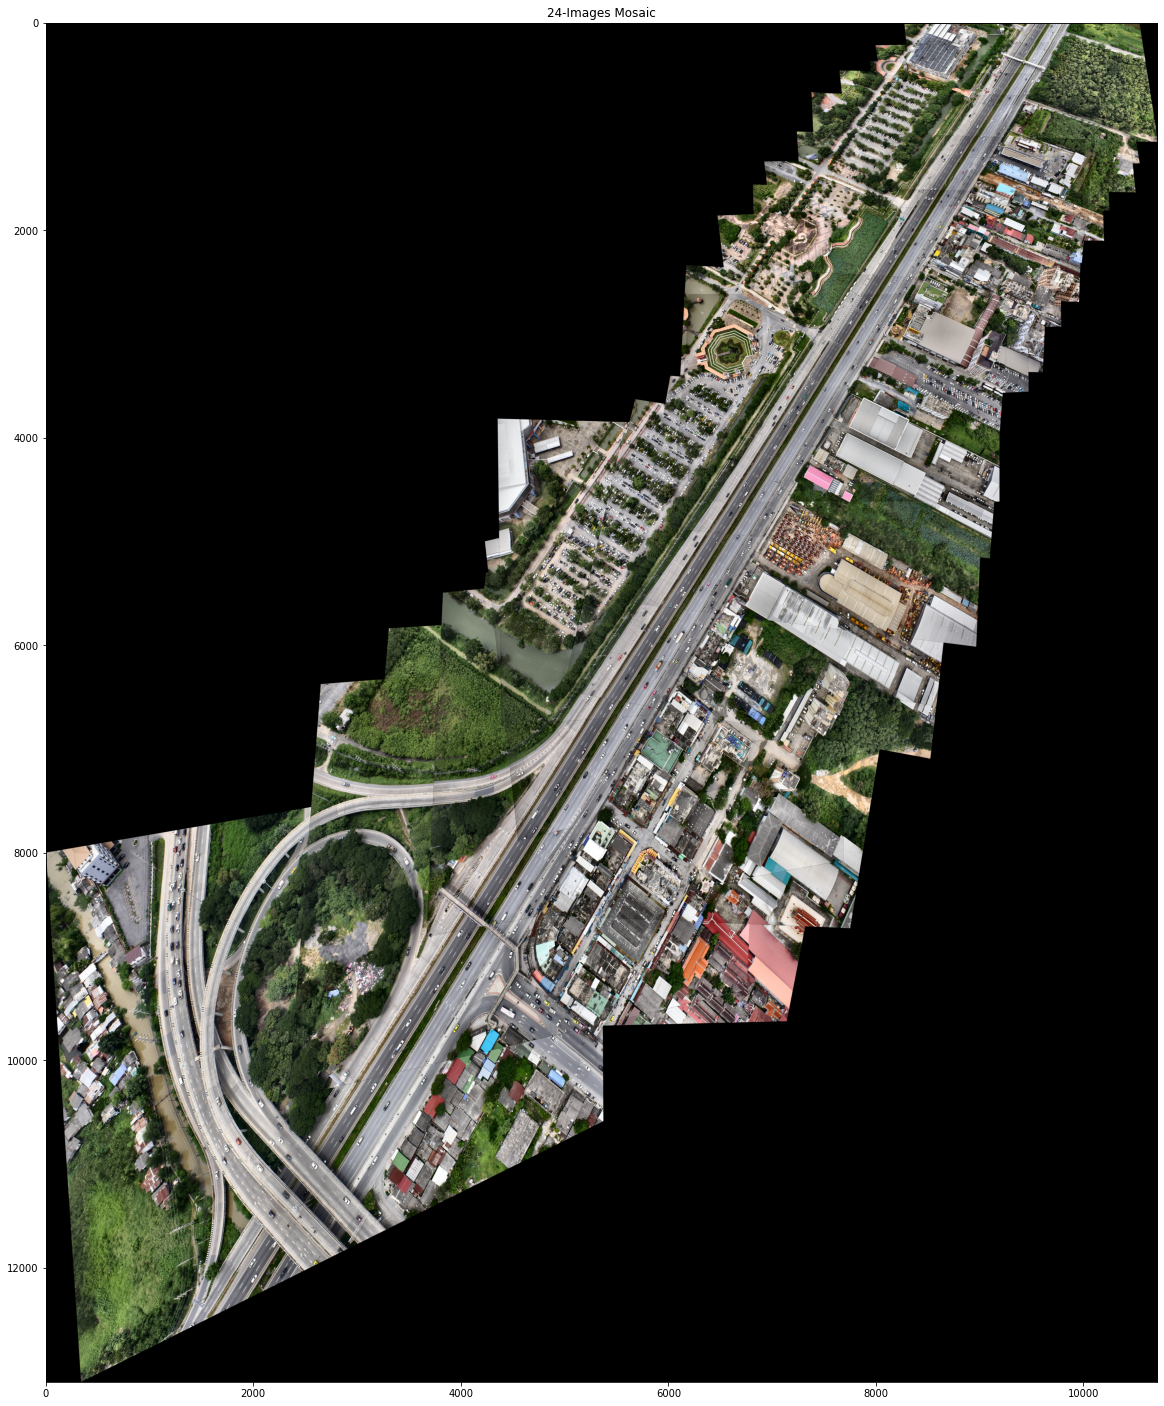

In [28]:
plt.figure(figsize = (25,25))


plt.imshow(cv2.cvtColor(combined_warp_n, cv2.COLOR_BGR2RGB))
plt.title('24-Images Mosaic')

## **To-Do Tasks**

*  Seam Removal
*  Improve On this Enhancement
*  Extend to 50 images